# Carregar as bibliotecas

In [554]:
import numpy as np
from skimage import io, data, filters, util, color, transform, exposure, morphology, feature
from scipy import ndimage, stats, fft
import matplotlib.pyplot as plt
from skimage.util import img_as_float, img_as_uint, img_as_ubyte

In [555]:
def show(img_list, caption_list, Axis=False, rescale = True):
    n = len(img_list)
    f, ax = plt.subplots(1,n, figsize=(10+5*(n-1),10))
    for i in range(n):
        if rescale:
            ax[i].imshow(img_list[i], cmap='gray')
        else:
            ax[i].imshow(img_list[i], cmap='gray', vmin=0, vmax=255)
        ax[i].set_title(caption_list[i])
        if not Axis:
            ax[i].set_axis_off()

In [556]:
def gridFourier(M, N):
    u = np.arange(0, M)
    v = np.arange(0, N)

    u = u - np.floor(M/2)
    v = v - np.floor(N/2)
    U, V = np.meshgrid(u, v)
    return U, V

In [557]:
def mapping(img):
    nimg = util.img_as_float(img)
    mmin = np.min(nimg)
    nimg = nimg - mmin
    mmax = np.max(nimg)
    return (nimg/mmax)*255

In [558]:
def log_imshow(img):
    return np.log( np.abs(img)+1 )

In [559]:
def passa_freq(img, mask):
    height, width = img.shape[:2]
    fimg = fft.fftshift( fft.fft2(img) )
    fimg = fimg * mask
    nimg = fft.ifft2(fimg)
    nimg = np.abs(nimg)
    return nimg, fimg

# Questão 1

<p align="justify">
Dada a seguinte imagem, eliminar o ruído produzido pelo ruído periódico. Na figura abaixo é mostrado a imagem ruidosa e seu respectivo espectro de Fourier. Pode-se observar que existem dois pares de "spikes" (assinalados com a seta vermelha e amarela). Os ``spikes'' estão localizados nas coordenadas (36,10) e (72,-24). Utilize um filtro Notch Butterworth para apagar os coeficiente ao redor dos spikes.
</p>

<p align="justify">

</p>

<table><tr>
<td> <img src="https://drive.google.com/uc?id=10O_eu9WzBZzpTR1ila3R8wZ0SDzkM2kF" alt="Drawing"  width="500"/> </td>
<td> <img src="https://drive.google.com/uc?id=1cWr8WzFa6lHwyCFK1_iDOsrKu-lGqM1I" alt="Drawing"  width="500"/> </td>

</tr></table>



<p align"justify">
Filtro notch: São filtros capazes de rejeitar uma faixa bastante estreita de frequências. Sua utilização é recomendada quando o sinal a ser atenuado é bem definido. Pelo fato de atuar em faixas reduzidas de frequências, filtros notch interferem pouco na qualidade do sinal. A figura a continuação mostra apenas um par de regiões sendo retirado.
</p>

<img src="https://drive.google.com/uc?id=1L4J9Y6yFpKMebHyceWb1cy7j6CWljixO" alt="Drawing"  width="500"/>

<p align"justify">
A área em torno da frequência de corte escolhida ($D_0$) que pode ser retirada é definida na construção do filtro. Seja $D_0$ a frequência de corte do filtro notch centrado em ($u_0, v_0$) e, por simetria ($-u_0, -v_0$):

$$D_1(u,v) = \sqrt{(u - M/2 - u_0)^2 + (v - N/2 - v_0)^2}$$

$$D_2(u,v) = \sqrt{(u - M/2 + u_0)^2 + (v - N/2 + v_0)^2}$$

$$H(u,v) = \frac{1}{1 + \left(\frac{D_0^2}{D_1(u,v)D_2(u,v)}\right)^{2n}}$$

Crie um filtro notch para remover a ruído periódico
</p>


In [560]:
img = io.imread('https://drive.google.com/uc?id=10O_eu9WzBZzpTR1ila3R8wZ0SDzkM2kF')

In [561]:
def mask_butterworth_notch(width, height, d0, n, u, v):
    U, V = gridFourier(width, height)
    D1 = np.sqrt( (U-u)**2 + (V-v)**2 )
    D2 = np.sqrt( (U+u)**2 + (V+v)**2 )
    H = 1 / (1 + ( (d0**2)/(D1*D2) )**(2*n))
    return H


<ipython-input-561-7e58e33ee840>:5: RuntimeWarning: divide by zero encountered in divide
  H = 1 / (1 + ( (d0**2)/(D1*D2) )**(2*n))


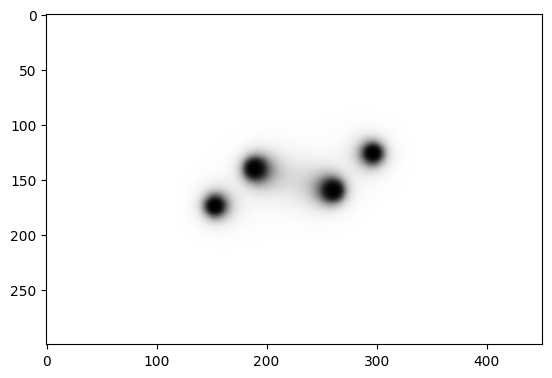

In [562]:
lin, col = img.shape[:2]
H1 = (36, 10)
H2 = (72, -24)
HN = mask_butterworth_notch(col, lin, 30, 2, H1[0], H1[1]) * mask_butterworth_notch(col, lin, 40, 2, H2[0], H2[1])
plt.imshow(HN, cmap='gray',vmin=0, vmax=1)

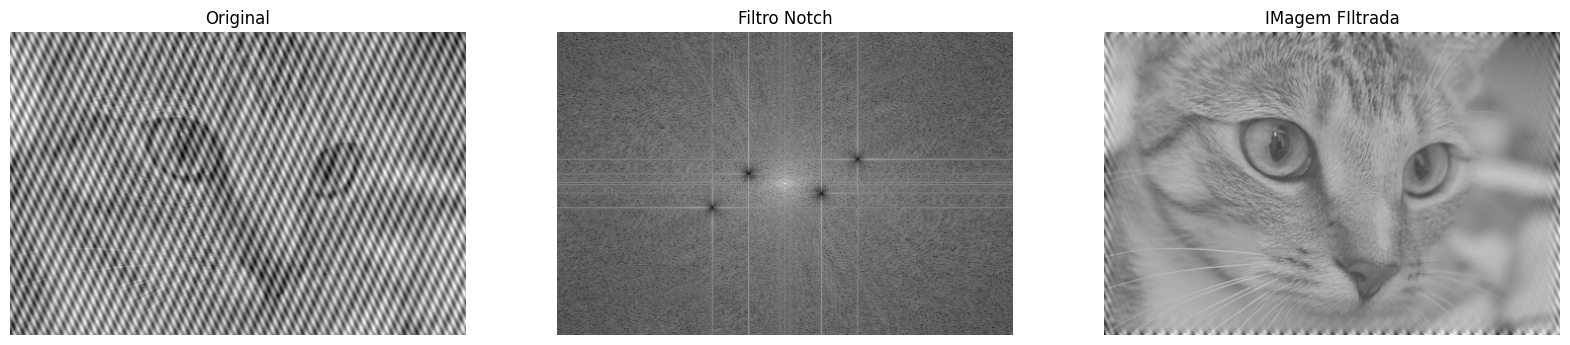

In [563]:
nimg, fimg = passa_freq(img, HN)
show([img, np.log(np.abs(fimg)+1), nimg], ['Original','Filtro Notch', 'IMagem FIltrada'])

# Questão 2
<p align="justify">
Repita o processo de remoção do ruído periódico da questão anterior utilizando os seguintes filtro passa-bandas: ideal, Butterworth e Gaussiano.
<p>

<p align="justify">
Filtro Ideal:
$$H(u,v) = \begin{cases}
0 & \text{se } D_0-\frac{W}{2} \leq D \leq D_0 + \frac{W}{2}\\
1 & \text{otherwise}
\end{cases} $$
<p>

<p align="justify">
Filtro Butterworth:
$$H(u,v) = \frac{1}{1 + \left(\frac{D.W}{D^2 - D_0^2}\right)^{2n}}$$
<p>

<p align="justify">
Filtro Gaussiano:
$$H(u,v) = 1 - e^{-  \left(\frac{D^2 - D_0^2}{D.W} \right)^2 }$$
<p>

In [564]:
def mask_ideal_band(width, height, d0, W):
    U, V = gridFourier(width, height)
    D = np.sqrt(U**2 + V**2)
    H = np.ones((height, width))
    H[(D >= d0 - (W / 2)) & (D <= d0 + (W / 2))] = 0
    H[(D >= 2 * d0 - (W / 2)) & (D <= 2 * d0 + (W / 2))] = 0

    return H


In [565]:
def mask_butterworth_band(width, height, d0, n, W):
    U, V = gridFourier(width, height)
    D = np.sqrt(U**2 + V**2)
    H1 = 1 / (1 + ((D*W)/(D**2 - d0**2))**(2*n))
    H2 = 1 / (1 + ((D*W)/(D**2 - 4*d0**2))**(2*n))
    return H1 * H2


In [566]:
def mask_gaussian_band(width, height, d0,  W):
    U, V = gridFourier(width, height)
    D = np.sqrt(U**2 + V**2)
    e = np.exp( - ( (D**2 - d0**2)/(D*W) )**2 )
    H1 = 1 - e
    e = np.exp( - ( (D**2 - 4*d0**2)/(D*W) )**2 )
    H2 = 1 - e
    return H1 * H2

<ipython-input-565-e124b72622fa>:4: RuntimeWarning: divide by zero encountered in divide
  H1 = 1 / (1 + ((D*W)/(D**2 - d0**2))**(2*n))
<ipython-input-565-e124b72622fa>:5: RuntimeWarning: divide by zero encountered in divide
  H2 = 1 / (1 + ((D*W)/(D**2 - 4*d0**2))**(2*n))
<ipython-input-566-68565d7498bd>:6: RuntimeWarning: divide by zero encountered in divide
  e = np.exp( - ( (D**2 - 4*d0**2)/(D*W) )**2 )


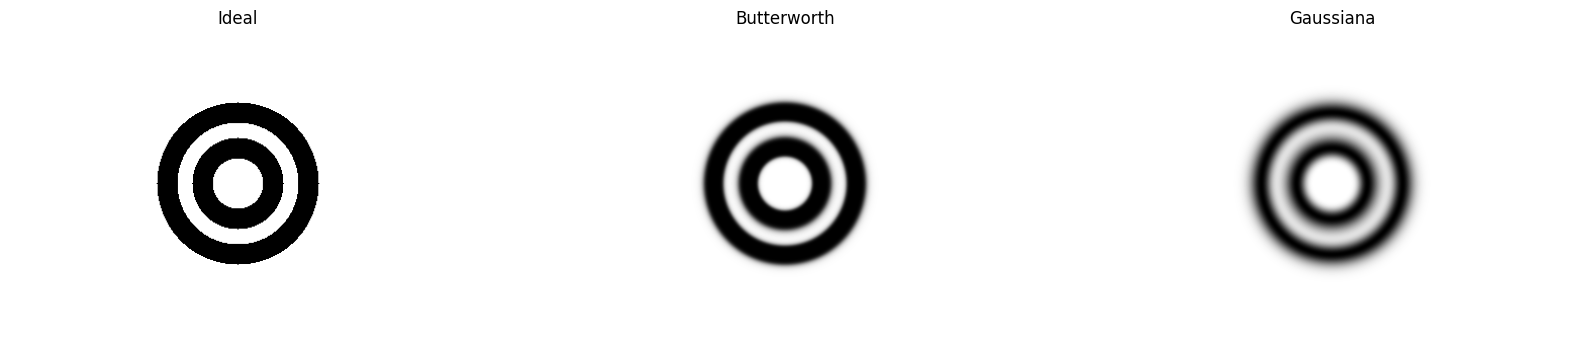

In [567]:
x = 35
y = 20

HI = mask_ideal_band(col, lin, x, y)
HB = mask_butterworth_band(col, lin, x, 4, y)
HG = mask_gaussian_band(col, lin, x, y)

show([HI, HB, HG], ['Ideal','Butterworth', 'Gaussiana'])

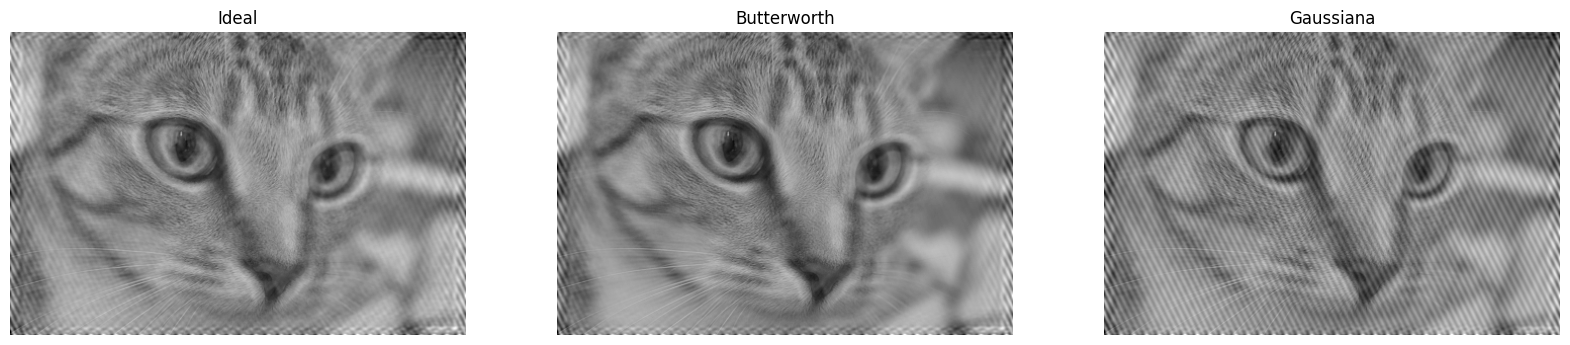

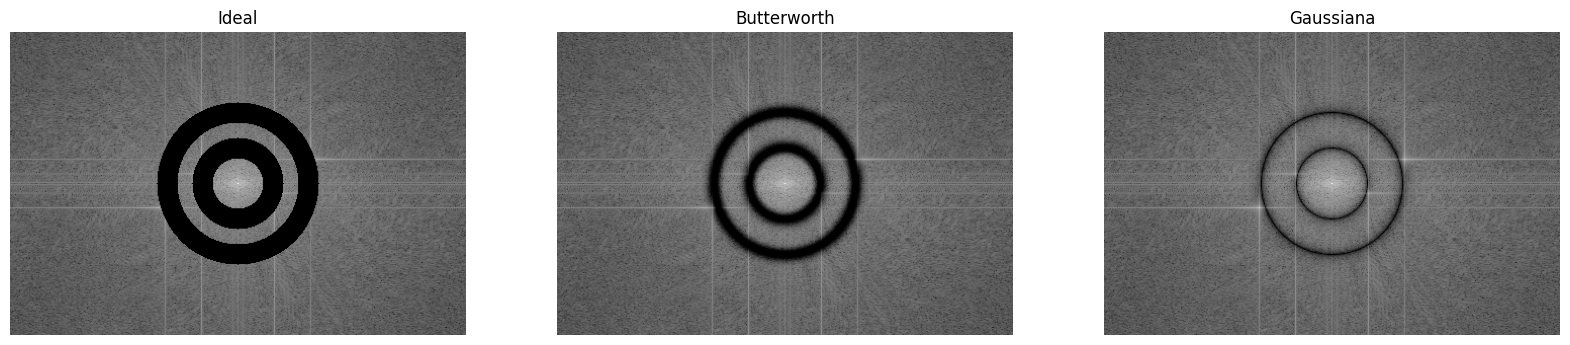

In [568]:
nimgI, fimgI = passa_freq(img, HI)
nimgB, fimgB = passa_freq(img, HB)
nimgG, fimgG = passa_freq(img, HG)

show([nimgI, nimgB, nimgG], ['Ideal','Butterworth', 'Gaussiana'])
show([np.log(np.abs(fimgI)+1), np.log(np.abs(fimgB)+1), np.log(np.abs(fimgG)+1)], ['Ideal','Butterworth', 'Gaussiana'])

## Questao 3
<p> Uma outra forma de realçar as bordas de uma imagem é através do Laplaciano. A continuação é definido o $\textit{unsharp masking}$ baseado no Laplaciano

$$f(x,y) + \alpha(\bigtriangledown^2f(x,y))$$
onde $\bigtriangledown^2f(x,y)$ é o Laplaciano da imagem $f(x,y)$ e $\alpha$ é um fator de escala. Implementar a função $\textit{unsharp masking}$
</p>

In [569]:
def highboost(img, alpha=-3):
    laplacian = filters.laplace(img)

    sharpened_img = img + alpha * laplacian

    sharpened_img = np.clip(sharpened_img, 0, 1)

    return sharpened_img

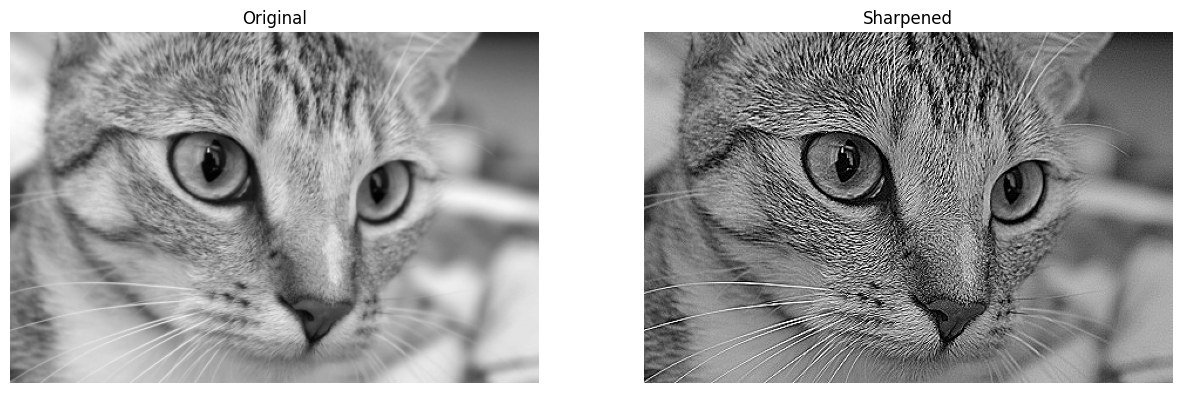

In [570]:
img = color.rgb2gray(data.chelsea())
nimg2 = highboost(img, alpha = 2)
show([img,nimg2 ],['Original', 'Sharpened'])

## Questao 4

<p>
Crie uma nova versão da seguinte imagem aplicando a função <i>modifica</i>
</p>
<img src="https://drive.google.com/uc?id=1lWiT-Wz7ZFhWRf-u__aqxwzaho6AtLG8" alt="Drawing"  width="300"/>
<p>
Logo, binarize a nova imagem gerada usando um filtro adaptativo.
</p>

In [571]:
def modifica2(img):
  fimg = util.img_as_float(img, force_copy=True)
  lin, col = fimg.shape[:2]
  x = np.ones((lin,1)) @ np.arange(col).reshape(1,col)
  nimg = fimg * ( x/2 + 50 ) + (1-fimg) * x/2
  return mapping(nimg)

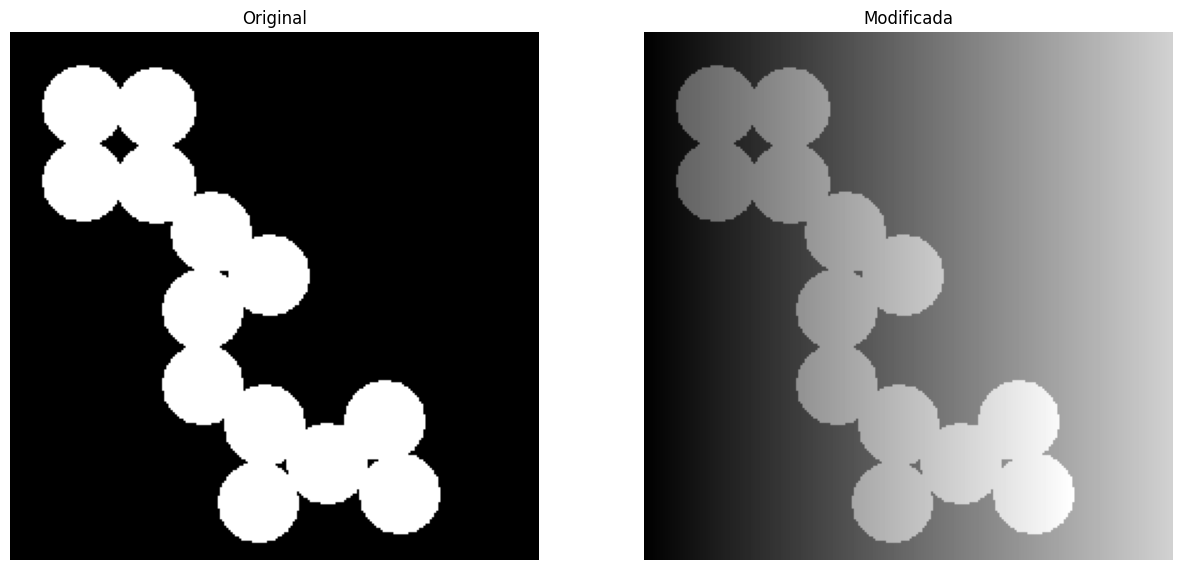

In [572]:
img = io.imread("https://drive.google.com/uc?id=1lWiT-Wz7ZFhWRf-u__aqxwzaho6AtLG8", as_gray=True)
nimg = modifica2(img)
show([img, nimg], ['Original', 'Modificada'])

In [573]:
def segmentacao_adaptativa(img, blocos_x, blocos_y):
    fimg = util.img_as_float(img)
    lin, col = fimg.shape[:2]
    nimg = np.zeros((lin, col))
    for i in range(blocos_x):
       for j in range(blocos_y):
             x = i*lin//blocos_x
             y = j*col//blocos_y
             bloco = fimg[x:x+lin//blocos_x, y:y+col//blocos_y]
             limiar = filters.threshold_otsu(bloco)
             nimg[x:x+lin//blocos_x, y:y+col//blocos_y] = bloco > limiar
    return nimg


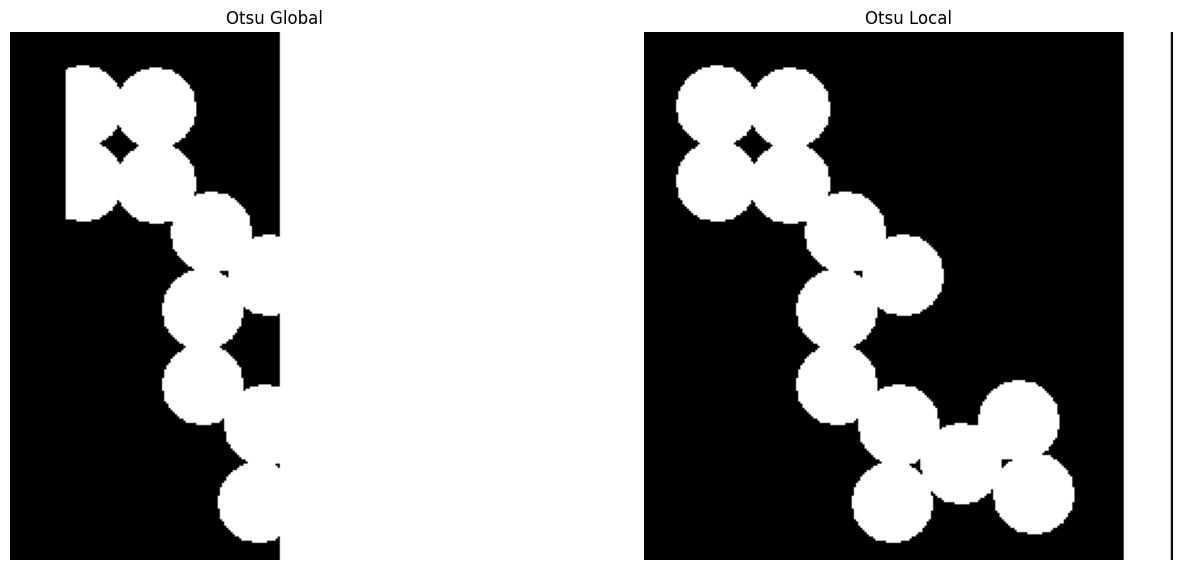

In [574]:
nimg2 = segmentacao_adaptativa(nimg, 1, 6)
thresh = filters.threshold_otsu(nimg)
nimg3 = nimg > thresh
show([nimg3, nimg2], ['Otsu Global', 'Otsu Local'])